# GAN-AE
Notebook with an exploration of the input and output of the GAN-AE algorithm
## Input
The pre-processed files have been donwloaded from [this link](https://onedrive.live.com/?authkey=%21APNzARJylhUVxt0&id=2C3CDD05B333D5E2%214457&cid=2C3CDD05B333D5E2). However, one can pre-process the data with the information in [this repository](https://gitlab.cern.ch/idinu/lhc-olympics-preprocessing/-/tree/master)

In [1]:
# Importing the main libraries
import pandas as pd
import numpy as np
import h5py
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib

I'm going to read the pre-processed files for the RnD dataset:

In [2]:
df_bkg = pd.read_hdf('..\data\RnD_bkg_HLF.h5')
df_sig1=pd.read_hdf('..\data\RnD_sig1_HLF.h5')
df_sig2 = pd.read_hdf('..\data\RnD_sig2_HLF.h5')

# All have the same columns
df_bkg.columns

Index(['pt1', 'eta1', 'phi1', 'E1', 'm1', 'nc1', 'nisj1', 'nesj1', '1tau1',
       '2tau1', '3tau1', '32tau1', '21tau1', 'pt2', 'eta2', 'phi2', 'E2', 'm2',
       'nc2', 'nisj2', 'nesj2', '1tau2', '2tau2', '3tau2', '32tau2', '21tau2',
       'eRing0_1', 'eRing1_1', 'eRing2_1', 'eRing3_1', 'eRing4_1', 'eRing5_1',
       'eRing6_1', 'eRing7_1', 'eRing8_1', 'eRing9_1', 'eRing0_2', 'eRing1_2',
       'eRing2_2', 'eRing3_2', 'eRing4_2', 'eRing5_2', 'eRing6_2', 'eRing7_2',
       'eRing8_2', 'eRing9_2', 'mjj', 'nj'],
      dtype='object')

In [3]:
# Let's see the shape
print(df_bkg.shape, df_sig1.shape, df_sig2.shape)

(1000000, 48) (100000, 48) (100000, 48)


According to a [presentation](https://www.dropbox.com/s/mml3xk6c4ecd9qr/lhco_lpc%20-%20Ioan%20Dinu.pdf?dl=0) these are the variables
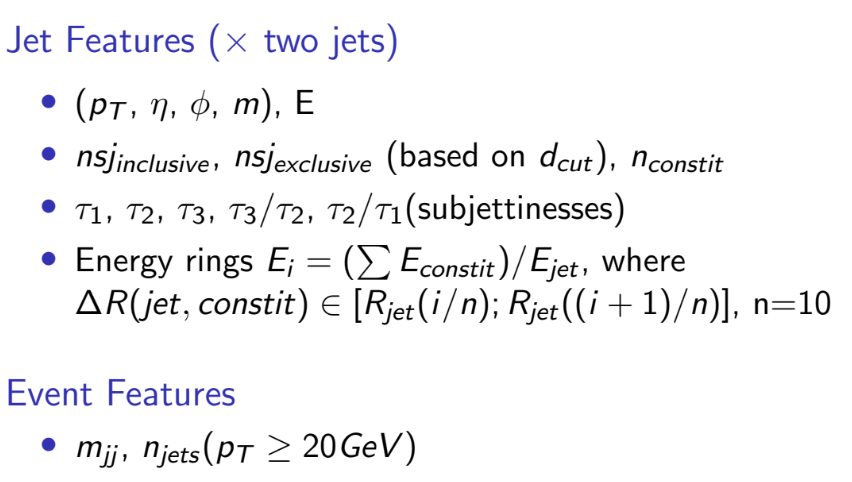 
I'll try to plot some things to understand the data

In [4]:
# I'll add a label variable to plot
df_bkg['label']=0
df_sig1['label']=1
df_sig2['label']=2

df = pd.concat([df_bkg, df_sig1, df_sig2])
df.head()

,pt1,eta1,phi1,E1,m1,nc1,nisj1,nesj1,1tau1,2tau1,...,eRing3_2,eRing4_2,eRing5_2,eRing6_2,eRing7_2,eRing8_2,eRing9_2,mjj,nj,label
0,1229.280156,0.748344,-1.661305,1602.606464,201.754287,48,18,47,0.057577,0.052557,...,0.172148,0.557333,0.213822,0.006539,0.021352,0.015475,0.008714,2537.199353,2,0
1,1607.061714,0.444502,-0.333945,1773.018798,127.116557,47,8,45,0.055647,0.030277,...,0.000000,0.000000,0.000000,0.006010,0.000000,0.000000,0.000000,3079.635449,4,0
2,1368.477022,0.150499,0.139019,1391.016561,139.497466,50,11,49,0.054010,0.031065,...,0.005496,0.002115,0.000000,0.001805,0.006821,0.004289,0.057382,3136.738161,3,0
3,1524.740761,-0.200242,-2.698075,1555.979990,42.044170,20,4,20,0.011612,0.011410,...,0.022763,0.012305,0.006580,0.002522,0.000000,0.002736,0.002287,3105.888967,3,0
4,1396.152785,-0.616216,-0.567546,1673.046873,105.413577,40,14,37,0.018161,0.018878,...,0.045628,0.012304,0.066874,0.042299,0.031090,0.015182,0.019944,2915.201089,4,0


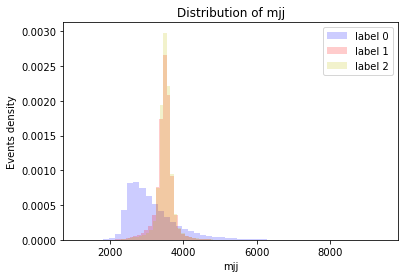

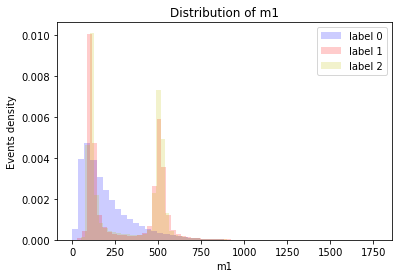

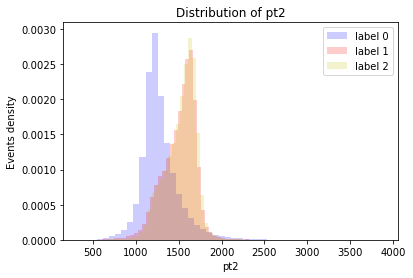

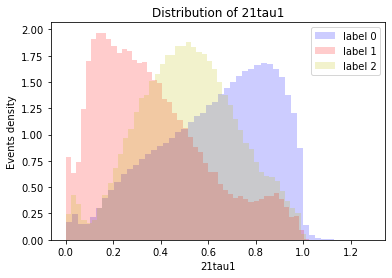

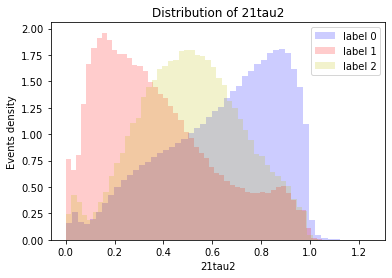

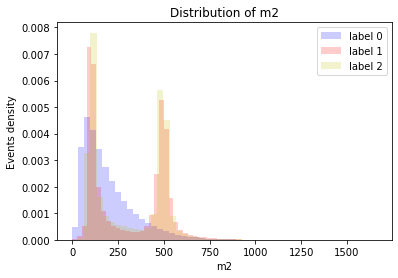

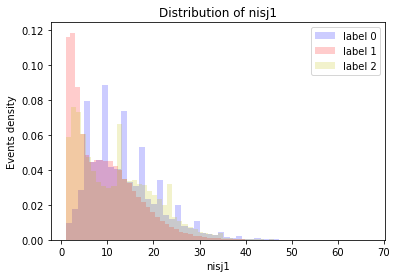

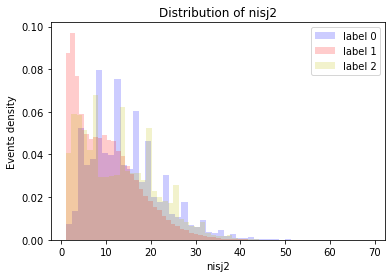

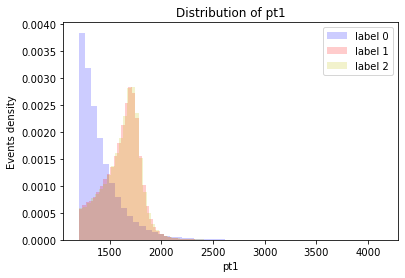

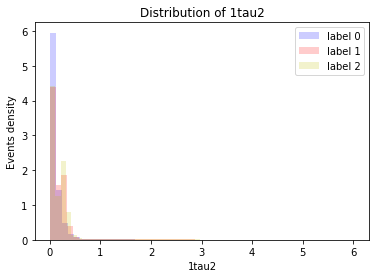

In [5]:
from benchtools.src.plotools import bkg_sig_hist

# I'll list some variables according to 
# the feature importance on the presentation
some_variables = ['mjj', 'm1', 'pt2', '21tau1', '21tau2', 'm2', 
                  'nisj1', 'nisj2', 'pt1', '1tau2']
for variable in some_variables:
    bkg_sig_hist(df, variable, label='label')
    plt.show();

Where it looks orange is because signal 1 (label 1) and signal 2 (label 2) have the same distribution.

## Test set
I'll check the distances 

In [6]:
# Importing ploted metrics
from benchtools.src.metrictools import rejection_plot, inverse_roc_plot, significance_plot, precision_recall_plot

In [7]:
# Reading the distances
dist_bkg = pd.DataFrame(np.array(h5py.File('..\data\RnD_distances.h5', 'r')['bkg']), columns=['y_score'])
dist_sig1 = pd.DataFrame(np.array(h5py.File('..\data\RnD_distances.h5', 'r')['sig1']), columns=['y_score'])
dist_sig2 = pd.DataFrame(np.array(h5py.File('..\data\RnD_distances.h5', 'r')['sig2']), columns=['y_score'])

# Adding labels, 0 for background and 1 for signal
dist_bkg['label']=0
dist_sig1['label']=1
dist_sig2['label']=1

# Getting together each signal with the background
df_sig1 = pd.concat([dist_bkg, dist_sig1])
df_sig2 = pd.concat([dist_bkg, dist_sig2])

### Signal efficiency vs. background rejection

In [8]:
# Listing the values for plotting and comparing
names=['signal 1', 'signal 2']
scores = [df_sig1.loc[:,'y_score'], df_sig2.loc[:,'y_score']]
labels = [df_sig1.loc[:,'label'], df_sig2.loc[:,'label']]

In [107]:
def rejection_plot(names, labels, probs, colors=LIST_COLORS):
    '''Plots the signal efficiency (tpr) vs. the background rejection (1-fpr).

    Parameters
    ----------
    names : string or list of strings
        Name of the algorithms.

    labels: ndarray or list of ndarrays
        True label of every event.

    probs : ndarray or list of ndarrays
        Target scores, can either be probability estimates of the positive class, 
        confidence values, or non-thresholded measure of decisions.

    colors: list 
        List of specific colors for the curves (default is LIST_COLORS)
        
    Returns
    ------
    ax:
        The axis for the plot.
    '''

    # Creating the figure an the axis
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)

    # Setting some parameters
    matplotlib.rcParams.update({'font.size': 14})
    plt.grid()

    # For plotting just one curve
    if type(probs) is not list:

        # Selecting color in case it wasn't specified
        if type(colors) is not string: 
            colors = LIST_COLORS[0]

        fpr, tpr, roc_auc = roc_curve_and_score(labels, probs)
        plt.plot(1-fpr, tpr, color=colors, lw=2, label='{} AUC={:.3f}'.format(names, roc_auc))

    # For plotting multiple curves
    else: 
        # Plotting the curves

        # Different labels
        if type(labels)==list:
            for name, label, prob, color in zip(names, labels, probs, colors):
                fpr, tpr, roc_auc = roc_curve_and_score(label, prob)
                plt.plot(1-fpr, tpr, color=color, lw=2, label='{} AUC={:.3f}'.format(name, roc_auc))

        # Same label
        else:
            for name, prob, color in zip(names, probs, colors):
                fpr, tpr, roc_auc = roc_curve_and_score(labels, prob)
                plt.plot(1-fpr, tpr, color=color, lw=2, label='{} AUC={:.3f}'.format(name, roc_auc))

    # Plotting the line for a random classifier
    plt.plot(1-tpr, tpr, color='navy', lw=1, linestyle='--', label='Random classification')

    # Adding information to the plot
    plt.legend(loc="lower left")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Background rejection')
    plt.ylabel('Signal efficiency')
    plt.title('Rejection ROC')

    return ax


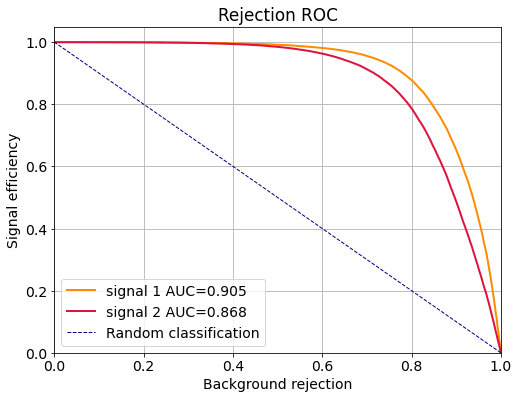

In [108]:
rejection_plot(names=names, labels=labels, probs=scores)
plt.show()

This agrees with the obtained result from the training:
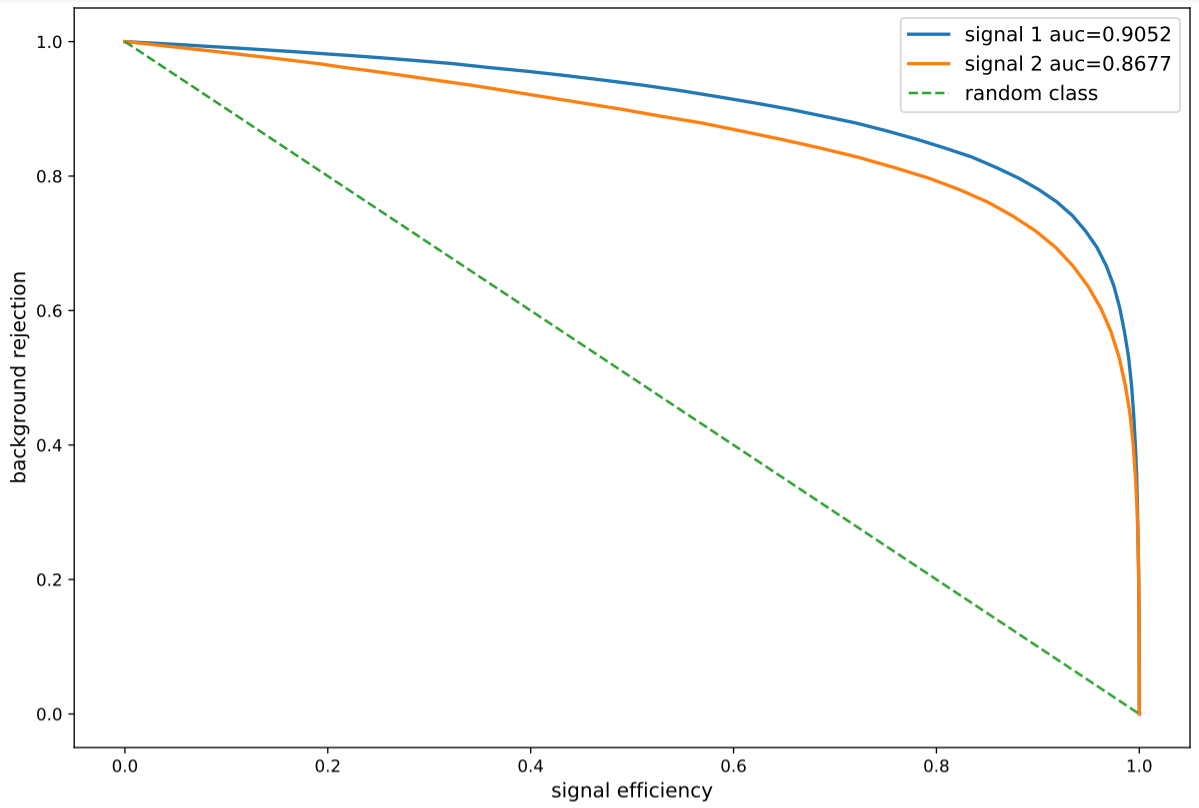

### Inverse ROC

In [97]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, precision_score, log_loss, recall_score, classification_report, f1_score, average_precision_score

LIST_COLORS = ['darkorange', 'crimson', 'green', 'blue', 'green'
    , 'red', 'purple', 'pink', 'gray', 'olive', 'cyan', 'indigo'
    ,'salmon','gold', 'aquamarine', 'bluevioles', 'magenta', 'darkred'
    ,'sandybrown', 'darkseagreen','deepskyblue', 'deeppink']

def roc_curve_and_score(label, pred_proba):
    '''Returns the false positive rate (fpr), true positive rate(tpr) and
    the area under the curve (auc) of the ROC curve.
    Parameters
    ----------
    label : ndarray
        True binary labels.
    pred_proba : ndarray
        Target scores, can either be probability estimates of the positive class, 
        confidence values, or non-thresholded measure of decisions.
    Returns
    ------
    fpr: ndarray
        False positive rate.
    tpr: ndarray
        True positive rate.
    auc: float
        AUC score.
    '''
    fpr, tpr, _ = roc_curve(label.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(label.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

def inverse_roc_plot(names, labels, probs, colors=LIST_COLORS):
    '''Plots the signal efficiency (tpr) vs. rejection (1/fpr).
    Parameters
    ----------
    names : string or list of strings
        Name of the algorithms.
    labels: ndarray or list of ndarrays
        True label of every event.
    probs : ndarray or list of ndarrays
        Target scores, can either be probability estimates of the positive class, 
        confidence values, or non-thresholded measure of decisions.
    colors: list 
        List of specific colors for the curves (default is LIST_COLORS)
        
    Returns
    ------
    ax:
        The axis for the plot.
    '''
    # To ignore division by zero error
    np.seterr(divide='ignore')

    # For plotting one curve
    if type(probs) is not list:
        # Creating the figure an the axis
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(1, 1, 1)

        # Setting some parameters
        matplotlib.rcParams.update({'font.size': 14})
        plt.grid()
        
        # In case there is no selected color
        if type(colors) is not string:
            colors = LIST_COLORS[0]

        # Plotting the curve
        fpr, tpr, _ = roc_curve_and_score(labels, probs)
        plt.plot(tpr, 1/fpr, color=colors, lw=2, label='{}'.format(names))

    # Multiple curves
    else: 
        # Creating the figure an the axis
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(1, 1, 1)

        # Setting some parameters
        matplotlib.rcParams.update({'font.size': 14})
        plt.grid()
        
        # Plotting the curves
        # Different labels
        if type(labels)==list:
            for name, label, prob, color in zip(names, labels, probs, colors):
                fpr, tpr, _ = roc_curve_and_score(label, prob)
                print(fpr.shape, label.shape)
                plt.plot(tpr, 1/fpr, color=color, lw=2, label='{}'.format(name))

        # Same labels
        else:
            for name, prob, color in zip(names, probs, colors):
                fpr, tpr, _ = roc_curve_and_score(labels, prob)
                plt.plot(tpr, 1/fpr, color=color, lw=2, label='{}'.format(name))
            # Radom classiffier
            #random = np.full((0, len(names)), 0.5)
            #fpr, tpr, _ = roc_curve_and_score(label, random)
            #plt.plot(tpr, 1/fpr, color=color, lw=2, label='{}'.format('random'))

    # Adding information to the plot
    plt.plot(tpr, 1/tpr, color='navy', lw=1, linestyle='--', label='Random classification')
    plt.legend(loc="upper right")
    plt.xlabel('Signal efficiency')
    plt.ylabel('Rejection')
    plt.title('Inverse ROC')
    ax.set_yscale('log')
    
    return ax

In [96]:
random = np.full((scores[0].shape), scores[0].mean())
print(scores[0].shape, random.shape)
fpr, tpr, _ = roc_curve_and_score(labels[0], random)
print(fpr, tpr)

(198494,) (198494,)
[0. 1.] [0. 1.]


(46352,) (198494,)
(55126,) (199077,)


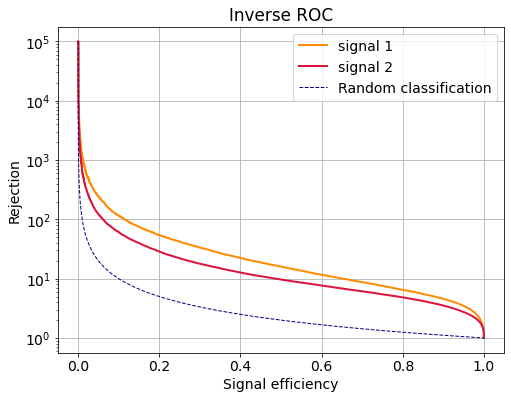

In [98]:
inverse_roc_plot(names=names, labels=labels, probs=scores)
plt.show()

### Significance

In [101]:
def significance_plot(names, labels, probs, colors=LIST_COLORS):
    
    # To ignore division by zero or NaN error
    np.seterr(divide='ignore', invalid='ignore')

    # Creating the figure an the axis
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)

    # Setting some parameters
    matplotlib.rcParams.update({'font.size': 14})
    plt.grid()

    # For plotting one curve
    if type(probs) is not list:
    
        # In case there is no selected color
        if type(colors) is not string:
            colors = LIST_COLORS[0]

        # Plotting the curve
        fpr, tpr, _ = roc_curve_and_score(labels, probs)
        plt.plot(tpr, tpr/np.sqrt(fpr), color=colors, lw=2, label='{}'.format(names))
    
    # Multiple curves
    else: 
        # Plotting the curves
        
        # For different labels
        if type(labels)==list:
                for name, label, prob, color in zip(names, labels, probs, colors):
                    fpr, tpr, _ = roc_curve_and_score(label, prob)
                    plt.plot(tpr, tpr/np.sqrt(fpr), color=color, lw=2, label='{}'.format(name))

        # Same labels
        else:
            for name, prob, color in zip(names, probs, colors):
                fpr, tpr, _ = roc_curve_and_score(labels, prob)
                plt.plot(tpr, tpr/np.sqrt(fpr), color=color, lw=2, label='{}'.format(name))

    # Adding information to the plot
    plt.plot(tpr, tpr/np.sqrt(tpr), color='navy', lw=1, linestyle='--', label='Random classification')
    plt.legend(loc="upper right")
    plt.xlabel('Signal efficiency')
    plt.ylabel('Significance improvement')
    plt.title('Significance ROC')
    
    return ax

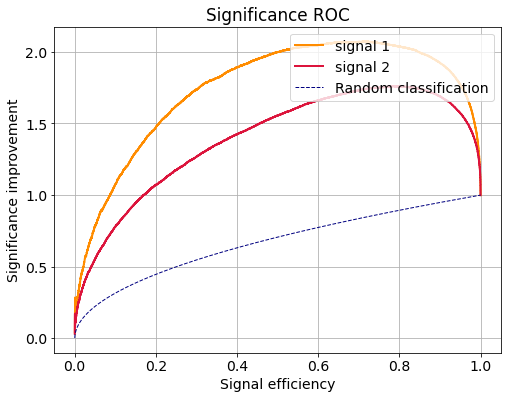

In [102]:
significance_plot(names=names, labels=labels, probs=scores)
plt.show()

### Precision vs. recall
This curve is better for data that is highly imbalanced

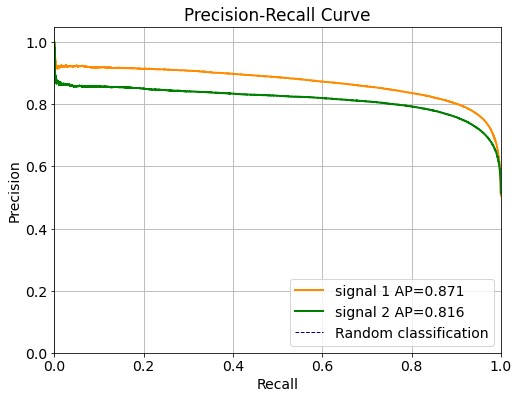

In [12]:
precision_recall_plot(names=names, labels=labels, probs=scores)
plt.show()

## Metrics
Here, I'll get the best thresholds for each signal and use them to calculate the metrics

In [13]:
from benchtools.src.metrictools import optimal_threshold, performance_metrics

In [14]:
threshold1 =optimal_threshold(labels[0], scores[0])
threshold2 =optimal_threshold(labels[1], scores[1])

print('Optimal thresholds: sig1 {0:.3}, sig2 {0:.3}'.format(threshold1, threshold2))

Optimal thresholds: sig1 0.706, sig2 0.706


In [15]:
df_sig1['y_pred']=(df_sig1['y_score'] >= threshold1).astype(float)
df_sig2['y_pred']=(df_sig2['y_score'] >= threshold2).astype(float)

log_cols=["Classifier", "Precision", "Recall", "F1 score"]
log = pd.DataFrame(columns=log_cols)

preds = [df_sig1.loc[:,'y_pred'], df_sig2.loc[:,'y_pred']]

for name, label, pred in zip(names, labels, preds):
    log_entry = performance_metrics(name, label, pred, pred_prob=None)
    log = log.append(log_entry)

log

signal 1
****Results****
              precision    recall  f1-score   support

  background       0.89      0.77      0.83    100000
      signal       0.80      0.91      0.85     98494

    accuracy                           0.84    198494
   macro avg       0.85      0.84      0.84    198494
weighted avg       0.85      0.84      0.84    198494

signal 2
****Results****
              precision    recall  f1-score   support

  background       0.87      0.73      0.79    100000
      signal       0.77      0.89      0.82     99077

    accuracy                           0.81    199077
   macro avg       0.82      0.81      0.81    199077
weighted avg       0.82      0.81      0.81    199077



,Classifier,Precision,Recall,F1 score
0,signal 1,79.813745,0.907558,0.849338
0,signal 2,76.532924,0.886381,0.821419


## Adding more background
The information gotten above is from the algorithm applied to 100,000 signal events and 100,000 background events. Realisticly this isn't the case. I tried running the algorithm with more background events, 500,000, to see if it affects the metrics.

In [16]:
# Reading the distances
dist_bkg = pd.DataFrame(np.array(h5py.File('..\data\RnD_distances_2.h5', 'r')['bkg']), columns=['y_score'])
dist_sig1 = pd.DataFrame(np.array(h5py.File('..\data\RnD_distances_2.h5', 'r')['sig1']), columns=['y_score'])
dist_sig2 = pd.DataFrame(np.array(h5py.File('..\data\RnD_distances_2.h5', 'r')['sig2']), columns=['y_score'])

# Adding labels, 0 for background and 1 for signal
dist_bkg['label']=0
dist_sig1['label']=1
dist_sig2['label']=1

# Getting together each signal with the background
df_sig1 = pd.concat([dist_bkg, dist_sig1])
df_sig2 = pd.concat([dist_bkg, dist_sig2])

In [17]:
# Listing the values for plotting and comparing
names = ['signal 1', 'signal 2']
scores = [df_sig1.loc[:,'y_score'], df_sig2.loc[:,'y_score']]
labels = [df_sig1.loc[:,'label'], df_sig2.loc[:,'label']]

### Plots

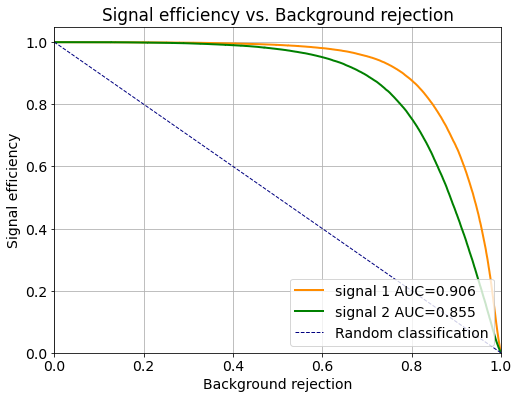

In [18]:
rejection_plot(names=names, labels=labels, probs=scores)
plt.show()

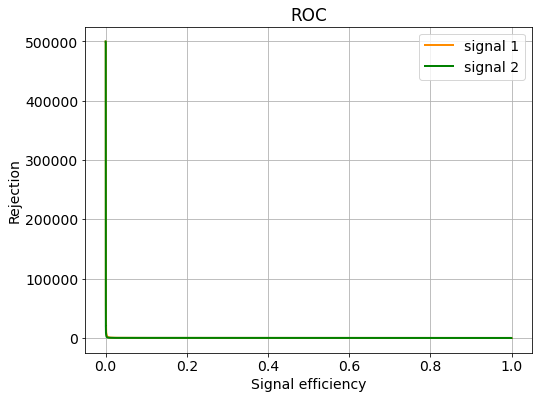

In [19]:
inverse_roc_plot(names=names, labels=labels, probs=scores)
plt.show()

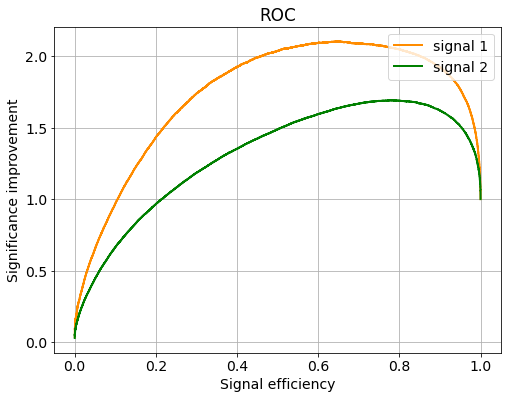

In [20]:
significance_plot(names=names, labels=labels, probs=scores)
plt.show()

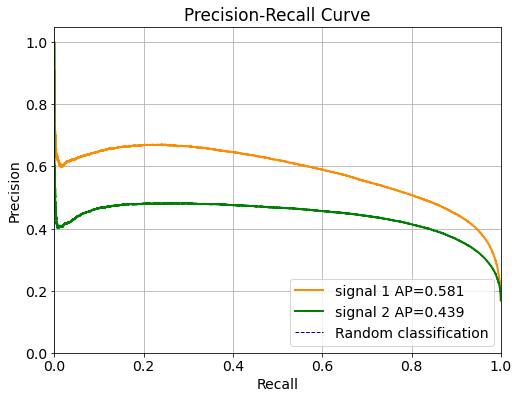

In [21]:
precision_recall_plot(names=names, labels=labels, probs=scores)
plt.show()

### Metrics

In [22]:
threshold1 =optimal_threshold(labels[0], scores[0])
threshold2 =optimal_threshold(labels[1], scores[1])

print('Optimal thresholds: sig1 {0:.3}, sig2 {0:.3}'.format(threshold1, threshold2))

Optimal thresholds: sig1 0.763, sig2 0.763


In [23]:
df_sig1['y_pred']=(df_sig1['y_score'] >= threshold1).astype(float)
df_sig2['y_pred']=(df_sig2['y_score'] >= threshold2).astype(float)

log_cols=["Classifier", "Precision", "Recall", "F1 score"]
log = pd.DataFrame(columns=log_cols)

preds = [df_sig1.loc[:,'y_pred'], df_sig2.loc[:,'y_pred']]

for name, label, pred in zip(names, labels, preds):
    log_entry = performance_metrics(name, label, pred, pred_prob=None)
    log = log.append(log_entry)

log

signal 1
****Results****
              precision    recall  f1-score   support

  background       0.98      0.78      0.87    500000
      signal       0.44      0.90      0.60     98494

    accuracy                           0.80    598494
   macro avg       0.71      0.84      0.73    598494
weighted avg       0.89      0.80      0.82    598494

signal 2
****Results****
              precision    recall  f1-score   support

  background       0.97      0.72      0.83    500000
      signal       0.38      0.87      0.53     99077

    accuracy                           0.75    599077
   macro avg       0.67      0.80      0.68    599077
weighted avg       0.87      0.75      0.78    599077



,Classifier,Precision,Recall,F1 score
0,signal 1,44.462610,0.902908,0.595839
0,signal 2,38.329151,0.872614,0.532629
